In [2]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import pathlib
import time
import cv2
import os

### Paths

In [4]:
images_path = '../../../Dataset/img_celeba_cropped' # all images 224x224
identity_path = '../../../Dataset/identity_CelebA.txt'
attributes_path = '../../../Dataset/list_attr_celeba.txt'

### Hyperparameters

In [5]:
pair_num=10000

train_size=0.6
test_val_proportion=0.5

network_input_shape=(224, 224, 3)

batch_size=32
lr=1e-5 #or 1e-5

- 10k
- contrastive loss
- lr=0.00001
- 30 batches
- base network

## Creating pairs

In [6]:
celeb_identity = pd.read_csv(identity_path, sep = " ", names=["image", "identity"])
celeb_identity["identity"] = celeb_identity["identity"].astype("string")

celeb_attrs = pd.read_csv(attributes_path, sep = "\s+")

In [7]:
def get_balanced_pair(column:str, pairing_column:str, df=celeb_identity):
    # getting random identity from the provided column to use for balanced pair
    random_id = df[column].sample(1, replace=True).to_string(index=False)
    containing_id_list = df.loc[df[column] == random_id][pairing_column].sample(2, replace=True).to_list()
    
    # random pictures for pair generation
    df_without_id = df.loc[df[column] != random_id]
    negative = df[pairing_column].sample(1).to_list()
    
    return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative[0], 0]]

In [8]:
balanced_pairs = []

for record in range(pair_num):
    pair = get_balanced_pair("identity", "image")
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df['left'] = images_path + '/' + df['left']
df['right'] = images_path + '/' + df['right']

In [9]:
df.head(10)

,left,right,label
0,../../../Dataset/img_celeba_cropped/202139.jpg,../../../Dataset/img_celeba_cropped/186109.jpg,1
1,../../../Dataset/img_celeba_cropped/202139.jpg,../../../Dataset/img_celeba_cropped/157776.jpg,0
2,../../../Dataset/img_celeba_cropped/119208.jpg,../../../Dataset/img_celeba_cropped/069223.jpg,1
3,../../../Dataset/img_celeba_cropped/119208.jpg,../../../Dataset/img_celeba_cropped/026729.jpg,0
4,../../../Dataset/img_celeba_cropped/142308.jpg,../../../Dataset/img_celeba_cropped/084410.jpg,1
5,../../../Dataset/img_celeba_cropped/142308.jpg,../../../Dataset/img_celeba_cropped/165617.jpg,0
6,../../../Dataset/img_celeba_cropped/193198.jpg,../../../Dataset/img_celeba_cropped/197007.jpg,1
7,../../../Dataset/img_celeba_cropped/193198.jpg,../../../Dataset/img_celeba_cropped/080444.jpg,0
8,../../../Dataset/img_celeba_cropped/002327.jpg,../../../Dataset/img_celeba_cropped/002327.jpg,1
9,../../../Dataset/img_celeba_cropped/002327.jpg,../../../Dataset/img_celeba_cropped/046470.jpg,0


### Create test train val split

In [10]:
X_train, X_rem, y_train, y_rem = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], train_size=train_size, random_state = 101, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=test_val_proportion)

In [11]:
print('=====Training=====')
print(X_train.shape)
print(y_train.shape)

print('=====Validation=====')
print(X_val.shape)
print(y_val.shape)

print('=====Testing=====')
print(X_test.shape)
print(y_val.shape)

=====Training=====
(12000, 2)
(12000, 1)
=====Validation=====
(4000, 2)
(4000, 1)
=====Testing=====
(4000, 2)
(4000, 1)


### Loading pairs into TF Dataset

In [12]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, (100, 100))
    img = tf.image.per_image_standardization(img)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [13]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [14]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

Metal device set to: Apple M1 Pro


2022-11-28 19:15:52.047695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 19:15:52.048012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## NN model

In [15]:
left_input = layers.Input(shape=network_input_shape, name='left_input')
right_input = layers.Input(shape=network_input_shape, name='right_input')

### ResNet50 model

In [16]:
trainable_layers=33 #whole conv_5 block

def resnet_network():
    input = layers.Input(shape=network_input_shape)
    
    resnet=ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        pooling='avg',
        weights='imagenet',
        classes=2)

    # whole conv5 block
    for layer in resnet.layers[0:-trainable_layers]:
        layer.trainable = False

    return Model(input, outputs=resnet.output, name='resnet50')

### Custom dense layers model

In [17]:
def base_network():
    input = layers.Input(shape=network_input_shape)
    x = layers.Flatten()(input)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(4096, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='base_network')

### Conv model

In [18]:
def conv_network(): 
    input = layers.Input(shape=network_input_shape, name='input_image')
    
    # First block
    c1 = layers.Conv2D(64, (10,10), activation='relu')(input)
    m1 = layers.MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = layers.Flatten()(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=input, outputs=d1, name='conv_net')

In [19]:
#base_model = resnet_network()
#base_model = conv_network()
base_model = base_network()

model_left = base_model(left_input)
model_right = base_model(right_input)

### Merging resnet branches layers

In [20]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [21]:
#model = layers.subtract([model_left, model_right])
model = layers.Lambda(euclidean_distance, name="merge")([model_left, model_right])

#model = layers.Dense(256, activation='relu')(model)
#model = layers.Dropout(.2)(model)
#model = layers.Dense(32, activation='relu')(model)
model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model, name='base_network')

### Loss funtions

In [22]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [23]:
def L1Dist(y_true, y_pred):
    return tf.math.abs(y_true - y_pred)

In [24]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1))

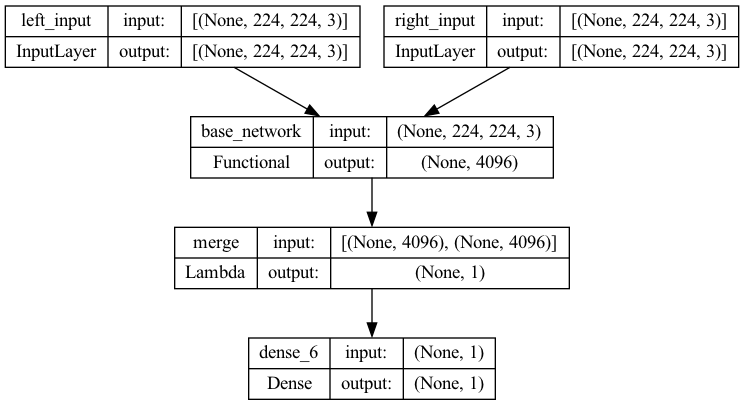

In [25]:
plot_model(model, show_shapes=True)

In [26]:
model.summary()

Model: "base_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_network (Functional)      (None, 4096)         186660864   ['left_input[0][0]',             
                                                                  'right_input[0][0]'] 

### Load existing model from a checkpoint

In [27]:
#checkpoint_dir = 'checkpoints/res_net-20221128-184233'
#latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

#model.load_weights(latest_ckpt)

### Train new model

In [ ]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=30)

checkpoints_path = 'checkpoints'
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

!cd {checkpoint_path} && mkdir {model_version}

model_path = f'{checkpoints_path}/{model_version}'
model.save_weights(model_path)

Epoch 1/30


2022-11-28 19:15:53.001952: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 19:15:53.302756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.2599

2022-11-28 19:17:09.155591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 89s 236ms/step - loss: 0.2599 - val_loss: 0.2489
Epoch 2/30
375/375 [==============================] - 118s 311ms/step - loss: 0.2498 - val_loss: 0.2478
Epoch 3/30
375/375 [==============================] - 117s 309ms/step - loss: 0.2490 - val_loss: 0.2472
Epoch 4/30
375/375 [==============================] - 117s 311ms/step - loss: 0.2483 - val_loss: 0.2499
Epoch 5/30
375/375 [==============================] - 116s 305ms/step - loss: 0.2471 - val_loss: 0.2442
Epoch 6/30
375/375 [==============================] - 114s 303ms/step - loss: 0.2436 - val_loss: 0.2430
Epoch 7/30
375/375 [==============================] - 302s 805ms/step - loss: 0.2386 - val_loss: 0.2426
Epoch 8/30
375/375 [==============================] - 121s 319ms/step - loss: 0.2310 - val_loss: 0.2435
Epoch 9/30
375/375 [==============================] - 119s 315ms/step - loss: 0.2263 - val_loss: 0.2422
Epoch 10/30
375/375 [==============================] - 119s 314ms/step - los

### Performance metrics

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

### Predictions

In [ ]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])


test_labels = y_test['label']

test_ds_full = create_dataset_no_labels(X_test)

In [ ]:
left_image_feature_vectors = base_model.predict(test_ds_left)
right_image_feature_vectors = base_model.predict(test_ds_right)

In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive distances

In [ ]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

### Negative distances

In [ ]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true)

In [ ]:
y_pred_test = euclidean_distance((left_image_feature_vectors, right_image_feature_vectors)).numpy().flatten()
cutoff = (positive_mean + negative_mean)/2

test_accuracy = compute_accuracy(test_labels, y_pred_test, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

In [ ]:
y_pred = y_pred_test.flatten() < cutoff

In [ ]:
confusion_matrix(test_labels, y_pred, labels = [1,0])